In [1]:
!git clone https://github.com/SteveMama/Differential-ViT.git ViTDiff

Cloning into 'ViTDiff'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 36 (delta 8), reused 33 (delta 5), pack-reused 0 (from 0)
Unpacking objects: 100% (36/36), done.


In [2]:
cd ViTDiff/

/scratch/kompally.p/ViTDiff


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from ViTDiff import *

In [7]:

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data Loading and Preprocessing
def load_cifar10(batch_size=128):
    """Load and preprocess CIFAR-10 dataset"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                           (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                           (0.2023, 0.1994, 0.2010))
    ])
    
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, 
                           shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, 
                          shuffle=False, num_workers=2)
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')
    
    return trainloader, testloader, classes

Using device: cuda


In [8]:
def train_epoch(model, trainloader, criterion, optimizer, scheduler, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader),
                       desc=f'Epoch {epoch+1}')
    
    for batch_idx, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        progress_bar.set_postfix({
            'Loss': running_loss/(batch_idx+1),
            'Acc': 100.*correct/total
        })
    
    if scheduler is not None:
        scheduler.step()
    
    return running_loss/len(trainloader), 100.*correct/total

def evaluate(model, testloader, criterion):
    """Evaluate the model"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    return test_loss/len(testloader), 100.*correct/total

In [9]:
def train_model(model, trainloader, testloader, num_epochs=100):
    """Complete training pipeline"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'best_acc': 0
    }
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, trainloader, criterion, 
                                          optimizer, scheduler, epoch)
        
        # Evaluate
        val_loss, val_acc = evaluate(model, testloader, criterion)
        
        # Save best model
        if val_acc > history['best_acc']:
            history['best_acc'] = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history

In [10]:
def plot_training_history(history):
    """Plot training curves"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def predict_sample(model, testloader, classes, num_samples=5):
    """Visualize predictions on sample images"""
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    
    with torch.no_grad():
        images = images[:num_samples].to(device)
        labels = labels[:num_samples]
        outputs = model(images)
        _, predicted = outputs.max(1)
        
    # Plot images with predictions
    fig = plt.figure(figsize=(15, 3))
    for idx in range(num_samples):
        ax = fig.add_subplot(1, num_samples, idx + 1)
        img = images[idx].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f'Pred: {classes[predicted[idx]]}\nTrue: {classes[labels[idx]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:

# Load data
trainloader, testloader, classes = load_cifar10(batch_size=128)

# Initialize model (using your VisionTransformerDiff from earlier)
model = VisionTransformerDiff(
    image_size=32,          # CIFAR-10 image size
    patch_size=4,           # 4x4 patches
    in_channels=3,          # RGB images
    num_classes=10,         # CIFAR-10 classes
    embed_dim=384,          # Embedding dimension
    depth=12,               # Number of transformer blocks
    num_heads=6,            # Number of attention heads
    mlp_ratio=4.,          
    qkv_bias=True,         
    drop_rate=0.1,         
    attn_drop_rate=0.1     
).to(device)



100%|██████████| 170498071/170498071 [00:01<00:00, 98336758.66it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [23]:

# Train model
history2 = train_model(model, trainloader, testloader, num_epochs=20)



Epoch 1: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s, Loss=0.271, Acc=90.3]



Epoch 1/20:
Train Loss: 0.2706, Train Acc: 90.34%
Val Loss: 1.0389, Val Acc: 71.86%


Epoch 2: 100%|██████████| 391/391 [00:40<00:00,  9.58it/s, Loss=0.258, Acc=90.8]



Epoch 2/20:
Train Loss: 0.2583, Train Acc: 90.80%
Val Loss: 0.9904, Val Acc: 72.68%


Epoch 3: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s, Loss=0.249, Acc=91.1]



Epoch 3/20:
Train Loss: 0.2485, Train Acc: 91.09%
Val Loss: 0.9986, Val Acc: 73.12%


Epoch 4: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s, Loss=0.226, Acc=91.9]



Epoch 4/20:
Train Loss: 0.2256, Train Acc: 91.93%
Val Loss: 1.0471, Val Acc: 72.33%


Epoch 5: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s, Loss=0.203, Acc=92.8]



Epoch 5/20:
Train Loss: 0.2034, Train Acc: 92.85%
Val Loss: 1.0812, Val Acc: 72.68%


Epoch 6: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s, Loss=0.186, Acc=93.4]



Epoch 6/20:
Train Loss: 0.1859, Train Acc: 93.37%
Val Loss: 1.0560, Val Acc: 72.97%


Epoch 7: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s, Loss=0.172, Acc=93.9]



Epoch 7/20:
Train Loss: 0.1716, Train Acc: 93.88%
Val Loss: 1.1086, Val Acc: 72.77%


Epoch 8: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s, Loss=0.143, Acc=94.9]



Epoch 8/20:
Train Loss: 0.1428, Train Acc: 94.92%
Val Loss: 1.1353, Val Acc: 72.81%


Epoch 9: 100%|██████████| 391/391 [00:40<00:00,  9.55it/s, Loss=0.122, Acc=95.8]



Epoch 9/20:
Train Loss: 0.1217, Train Acc: 95.77%
Val Loss: 1.1535, Val Acc: 73.39%


Epoch 10: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s, Loss=0.0996, Acc=96.6]



Epoch 10/20:
Train Loss: 0.0996, Train Acc: 96.56%
Val Loss: 1.1422, Val Acc: 74.11%


Epoch 11: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s, Loss=0.0835, Acc=97.1]



Epoch 11/20:
Train Loss: 0.0835, Train Acc: 97.10%
Val Loss: 1.2109, Val Acc: 74.22%


Epoch 12: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s, Loss=0.06, Acc=97.9]  



Epoch 12/20:
Train Loss: 0.0600, Train Acc: 97.94%
Val Loss: 1.2853, Val Acc: 73.56%


Epoch 13: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s, Loss=0.0466, Acc=98.5]



Epoch 13/20:
Train Loss: 0.0466, Train Acc: 98.45%
Val Loss: 1.2726, Val Acc: 74.49%


Epoch 14: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s, Loss=0.032, Acc=99]   



Epoch 14/20:
Train Loss: 0.0320, Train Acc: 98.96%
Val Loss: 1.3407, Val Acc: 74.23%


Epoch 15: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, Loss=0.0247, Acc=99.2]



Epoch 15/20:
Train Loss: 0.0247, Train Acc: 99.17%
Val Loss: 1.3682, Val Acc: 74.89%


Epoch 16: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s, Loss=0.0193, Acc=99.4]



Epoch 16/20:
Train Loss: 0.0193, Train Acc: 99.39%
Val Loss: 1.3712, Val Acc: 75.02%


Epoch 17: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s, Loss=0.0116, Acc=99.7]



Epoch 17/20:
Train Loss: 0.0116, Train Acc: 99.66%
Val Loss: 1.3802, Val Acc: 75.41%


Epoch 18: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s, Loss=0.0108, Acc=99.7]



Epoch 18/20:
Train Loss: 0.0108, Train Acc: 99.66%
Val Loss: 1.3864, Val Acc: 75.61%


Epoch 19: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, Loss=0.00796, Acc=99.8]



Epoch 19/20:
Train Loss: 0.0080, Train Acc: 99.78%
Val Loss: 1.3984, Val Acc: 75.47%


Epoch 20: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s, Loss=0.00731, Acc=99.8]



Epoch 20/20:
Train Loss: 0.0073, Train Acc: 99.81%
Val Loss: 1.3958, Val Acc: 75.61%


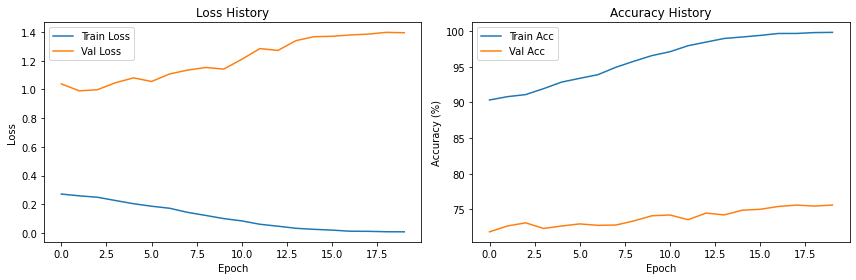

In [24]:
plot_training_history(history2)



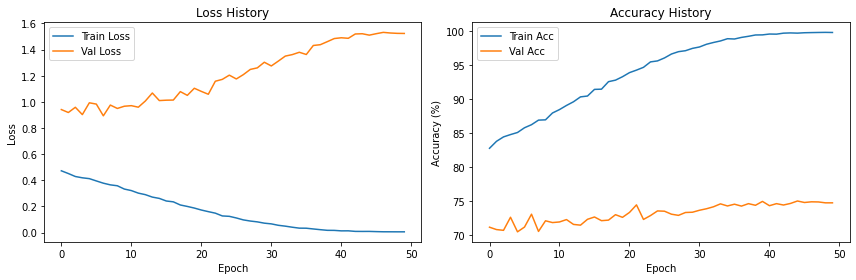

In [19]:
plot_training_history(history)



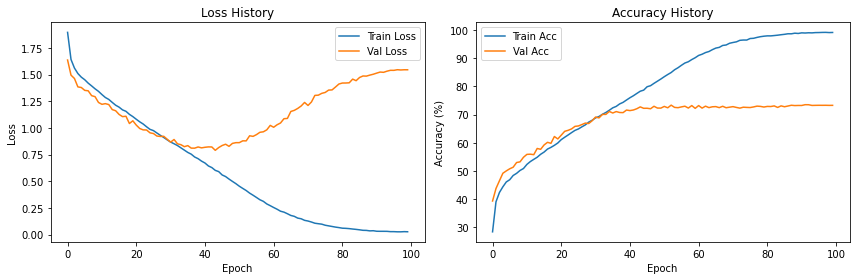

In [13]:

plot_training_history(history)



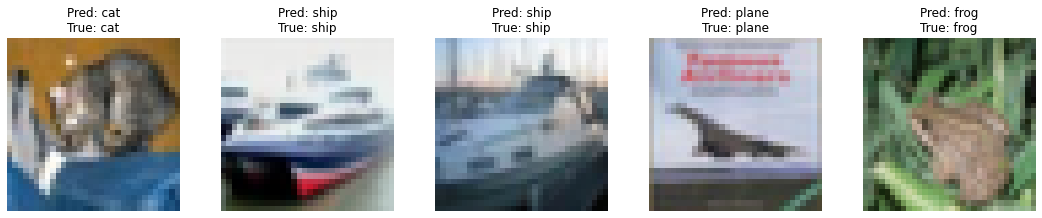


Final Test Accuracy: 73.52%


In [15]:

model.load_state_dict(torch.load('best_model.pth'))
predict_sample(model, testloader, classes)

test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss())
print(f'\nFinal Test Accuracy: {test_acc:.2f}%')

In [ ]:
history_2 =  plot_training_history(history)



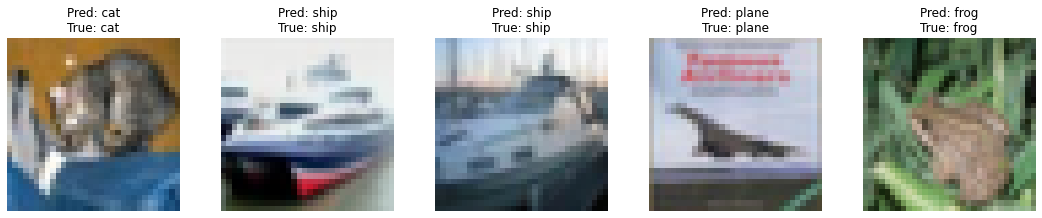


Final Test Accuracy: 75.05%


In [20]:

model.load_state_dict(torch.load('best_model.pth'))
predict_sample(model, testloader, classes)

test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss())
print(f'\nFinal Test Accuracy: {test_acc:.2f}%')

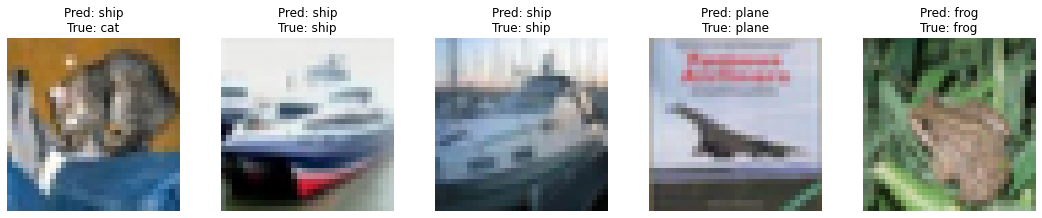


Final Test Accuracy: 75.61%


In [25]:

model.load_state_dict(torch.load('best_model.pth'))
predict_sample(model, testloader, classes)

test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss())
print(f'\nFinal Test Accuracy: {test_acc:.2f}%')